In [1]:
# !pip install matplotlib

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle
import argparse
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser(description='This is a demonstration program')

# Here we add an argument to the parser, specifying the expected type, a help message, etc.
# parser.add_argument('-batch_size', type=str, required=True, help='Please provide a batch_size')

# args = parser.parse_args()

# Now we can use the argument value in our program.
# print(f'batch size: {args.batch_size}')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# batch_size = args.batch_size # to use the batch_size cmd arg -> python file_name.py -batch_size 32
batch_size = 64
block_size = 128
max_iters = 3000
learning_rate = 3e-4
eval_iters = 100
n_embd = 384
n_head = 4
n_layer = 4
dropout = 0.2

print(device)

cuda


In [3]:
chars = ""
with open("data/wizard_of_oz.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    chars = sorted(list(set(text)))
# chars = ""
#     with open("openwebtext/vocab.txt", 'r', encoding='utf-8') as f:
#         text = f.read()
#         chars = sorted(list(set(text)))
        
vocab_size = len(chars)

In [4]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

In [5]:
# memory map for using small snippets of text from a single file of any size
# def get_random_chunk(split):
#     filename = "openwebtext/train_split.txt" if split == 'train' else "openwebtext/val_split.txt"
#     with open(filename, 'rb') as f:
#         with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
#             # Determine the file size and a random position to start reading
#             file_size = len(mm)
#             start_pos = random.randint(0, (file_size) - block_size*batch_size)

#             # Seek to the random position and read the block of text
#             mm.seek(start_pos)
#             block = mm.read(block_size*batch_size-1)

#             # Decode the block to a string, ignoring any invalid byte sequences
#             decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            
#             # Train and test splits
#             data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
#     return data
# def get_random_chunk(split):
#     filename = "openwebtext/train_split.txt" if split == 'train' else "openwebtext/val_split.txt"
#     with open(filename, 'rb') as f:
#         with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
#             # Determine the file size and a random position to start reading
#             file_size = len(mm)
#             start_pos = random.randint(0, (file_size) - block_size*batch_size)

#             # Seek to the random position and read the block of text
#             mm.seek(start_pos)
#             block = mm.read(block_size*batch_size-1)

#             # Decode the block to a string, ignoring any invalid byte sequences
#             decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            
#             # Train and test splits
#             data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
#     return data

n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
# def get_batch(split):
#     data = get_random_chunk(split)
#     ix = torch.randint(len(data) - block_size, (batch_size,))
#     x = torch.stack([data[i:i+block_size] for i in ix])
#     y = torch.stack([data[i+1:i+block_size+1] for i in ix])
#     x, y = x.to(device), y.to(device)
#     return x, y

In [6]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# [1, 0, 0]
# [1, 0.6, 0]
# [1, 0.6, 0.4]
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
    
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = GPTLanguageModel(vocab_size)
# print('loading model parameters...')
# with open('model-01.pkl', 'rb') as f:
#     model = pickle.load(f)
# print('loaded successfully!')
m = model.to(device)



In [8]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
trains = []
losss = []

for iter in range(max_iters):
    # print(iter)
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")
        trains.append(losses['train'])
        losss.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
# print(loss.item())

with open('model-00.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')




step: 0, train loss: 4.429, val loss: 4.429
step: 100, train loss: 2.379, val loss: 2.423
step: 200, train loss: 2.181, val loss: 2.257
step: 300, train loss: 1.879, val loss: 2.009
step: 400, train loss: 1.666, val loss: 1.851
step: 500, train loss: 1.528, val loss: 1.757
step: 600, train loss: 1.422, val loss: 1.688
step: 700, train loss: 1.352, val loss: 1.642
step: 800, train loss: 1.294, val loss: 1.611
step: 900, train loss: 1.248, val loss: 1.580
step: 1000, train loss: 1.208, val loss: 1.569
step: 1100, train loss: 1.169, val loss: 1.578
step: 1200, train loss: 1.141, val loss: 1.550
step: 1300, train loss: 1.103, val loss: 1.537
step: 1400, train loss: 1.082, val loss: 1.546
step: 1500, train loss: 1.049, val loss: 1.522
step: 1600, train loss: 1.025, val loss: 1.533
step: 1700, train loss: 1.004, val loss: 1.532
step: 1800, train loss: 0.979, val loss: 1.537
step: 1900, train loss: 0.954, val loss: 1.555
step: 2000, train loss: 0.930, val loss: 1.553
step: 2100, train loss: 0

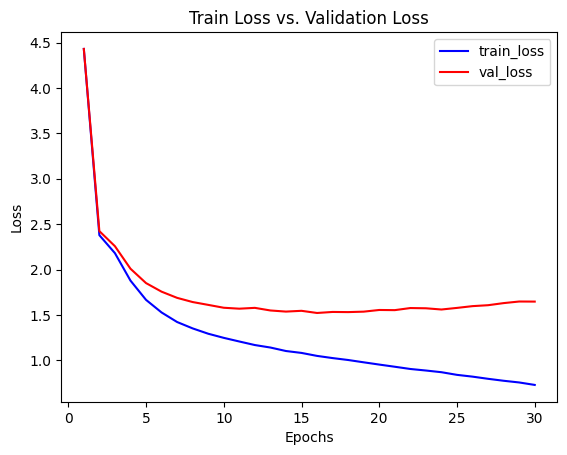

In [9]:
# Plotar train_loss e val_loss ao longo das épocas
epochs = range(1, len(trains) + 1)
plt.plot(epochs, trains, 'b', label='train_loss')
plt.plot(epochs, losss, 'r', label='val_loss')
plt.title('Train Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
prompt = 'Hello! Can you see me?'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

Hello! Can you see me?" it separing. "Some's
make givin' to get a great made fine?"

"I'd 'f you to place," said the creat
